# Descriptions

* Newly cropped images are able to contain images in four corners.
* Raw image -> img_crop_temp (3x3) has obj in the middle area -> img_crop_1, _2, _3, _4 have obj in one of the corner respectively.

In [41]:
# Load libraries
import os
import json 
import random
import urllib
import time

from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.models import load_model
import PIL

import utils

%matplotlib inline

# Load image

In [2]:
# Define image directory
projectDir=os.getcwd()
dataDir='..'
dataType='val2017'
imageDir='{}/images/'.format(dataDir)
annFile='{}/images/{}_selected/annotations/instances_{}.json'.format(dataDir,dataType,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile); print()

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!



In [4]:
obj_ids = coco.getAnnIds()

obj_id = random.choice(obj_ids)
obj_ann = coco.loadAnns(obj_id)[0]
img_ann = coco.loadImgs(obj_ann["image_id"])[0]

In [10]:
print(obj_ann)

{'segmentation': [[478.58, 393.96, 468.87, 391.31, 451.21, 397.49, 431.79, 411.62, 423.84, 423.97, 422.96, 435.45, 422.96, 445.16, 422.08, 446.93, 413.25, 453.11, 409.72, 459.29, 407.07, 466.35, 422.96, 473.41, 437.97, 508.72, 465.33, 580.23, 467.1, 590.82, 475.04, 623.49, 477.69, 500.78, 479.0, 430.15]], 'area': 7980.9404, 'iscrowd': 0, 'image_id': 168883, 'bbox': [407.07, 391.31, 71.93, 232.18], 'category_id': 1, 'id': 1751384}


In [11]:
print(img_ann)

{'license': 4, 'file_name': '000000168883.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000168883.jpg', 'height': 640, 'width': 479, 'date_captured': '2013-11-24 08:29:36', 'flickr_url': 'http://farm4.staticflickr.com/3477/4031027612_1547340e64_z.jpg', 'id': 168883}


# Load model

In [5]:
# load yolov3 model
model = utils.YOLOv3()

Model initialization completes.
/Users/haiho/anaconda3/envs/yolov3_huynhngocanh/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



fork 67.78457760810852
diningtable 88.88903260231018
broccoli 81.29059076309204
cup 63.425326347351074
fork 87.82025575637817
broccoli 72.1568763256073


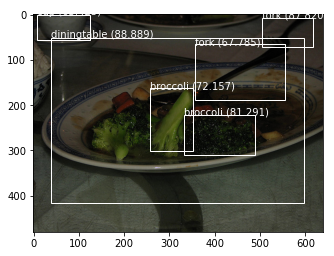

In [6]:
# test prediction on a single image
obj_id = random.choice(obj_ids)
obj_ann = coco.loadAnns(obj_id)[0]
img_ann = coco.loadImgs(obj_ann["image_id"])[0]

# load image
img = utils.load_image(img_ann["coco_url"], return_tensor=False)

# preprocessing
img_rsz = img.resize((416,416), resample=PIL.Image.BICUBIC)
img_rsz_tensor = utils.convert_to_tensor(img_rsz)

# predict
yhat = model.predict_image(img_rsz_tensor)
v_boxes, v_labels, v_scores = model.decode_prediction(yhat, img.size)

# show result
utils.show_result(img, v_boxes, v_labels, v_scores)


# Crop method

```
<-   224   ->
-------------
|           |
|           |
.     +     .
|   (x,y)   |
|           |
-------------
```

Original bbox coordinates should be converted into new coordinates in the cropped image.

In [7]:
class Preprocessor:
    def __init__(self, crop_edge=224):
        self.crop_edge = crop_edge

    def is_good_to_crop(self, bbox, img_sz):
        bbox_x, bbox_y, bbox_w, bbox_h = map(round,bbox)
        img_w, img_h = img_sz
        if (bbox_x + self.crop_edge > img_w) or (bbox_y + self.crop_edge > img_h):
            return False
        if (bbox_x + bbox_w - self.crop_edge < 0) or (bbox_y + bbox_h - self.crop_edge < 0):
            return False
        return True

    def get_crop_coordinates(self, bbox):
        """Returns a dictionary of 5 coordinates:
        [
            centr: None
            top_L: 0,0
            top_R: 0,1
            bot_L: 1,0
            bot_R: 1,1
        ]
        """
        bbox_x, bbox_y, bbox_w, bbox_h = map(round,bbox)
        labels = ['centr', 'top_L', 'top_R', 'bot_L', 'bot_R']
        corners = (None, [0,0], [0,1], [1,0], [1,1])
        w = self.crop_edge
        h = self.crop_edge
        
        crop_coordinates = dict()
        new_bbox = dict()
        for corner, label in zip(corners, labels):
            if corner is None:
                cent_x, cent_y = self._bbox_center((bbox_x, bbox_y, bbox_w, bbox_h))
                x = cent_x - self.crop_edge/2
                y = cent_y - self.crop_edge/2
                crop_coordinates[label] = list(map(int,[x, y, w, h]))

                new_bbox_x = bbox_x - x
                new_bbox_y = bbox_y - y
                new_bbox[label] = list(map(int,[new_bbox_x, new_bbox_y, bbox_w, bbox_h]))
            else:
                x = bbox_x + corner[1]*(bbox_w - self.crop_edge)
                y = bbox_y + corner[0]*(bbox_h - self.crop_edge)
                crop_coordinates[label] = list(map(int,[x, y, w, h]))

                new_bbox_x = corner[1]*(bbox_x - x)
                new_bbox_y = corner[0]*(bbox_y - y)
                new_bbox[label] = list(map(int,[new_bbox_x, new_bbox_y, bbox_w, bbox_h]))

        return crop_coordinates, new_bbox

    @staticmethod
    def _bbox_center(bbox):
        x, y, w, h = bbox
        center_x = round(x + w/2)
        center_y = round(y + h/2)
        return (center_x, center_y)


In [8]:
def get_bbox_width(bbox):
    return bbox[2]

def get_bbox_height(bbox):
    return bbox[3]

def get_category_dictionary():
    catLblFile='../images/val2017_selected/annotations/coco-labels-paper.txt'
    f = open(catLblFile, "r")
    category_name = list()
    for cat in f:
        category_name.append(cat)
    cat_dict = {i: category_name[i - 1].strip("\n") for i in range(1, len(category_name)+1)}
    return cat_dict

def mapping_labels(cat_id):
    cat_dict = get_category_dictionary()
    return(cat_dict[cat_id])

In [9]:
obj_anns = coco.loadAnns(obj_ids)
obj_anns_df = pd.DataFrame(obj_anns)

In [10]:
obj_anns_df['bbox_width'] = obj_anns_df['bbox'].apply(get_bbox_width)
obj_anns_df['bbox_height'] = obj_anns_df['bbox'].apply(get_bbox_height)

In [11]:
obj_anns_df['category_label'] = obj_anns_df['category_id'].apply(mapping_labels)

In [12]:
obj_anns_filtered = obj_anns_df[obj_anns_df['bbox_width'] < 112]
print(obj_anns_filtered.shape)
obj_anns_filtered = obj_anns_df[obj_anns_df['bbox_height'] < 112]
print(obj_anns_filtered.shape)
obj_anns_filtered = obj_anns_filtered[obj_anns_df['bbox_width'] < 112]
print(obj_anns_filtered.shape)


(26290, 10)
(24915, 10)
(22516, 10)
ipykernel_launcher:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [13]:
obj_anns_filtered.groupby(by="category_label").size().reset_index(name='counts').sort_values('counts', ascending=False)

,category_label,counts
49,person,6267
18,car,1610
22,chair,1191
12,book,1008
13,bottle,827
...,...,...
73,train,11
52,refrigerator,11
7,bed,8
35,hair drier,7


Results to be stored in csv format should have following columns:
* obj_id
* coco_url
* crop_area
* true_class
* true_bbox
* pred_class
* pred_bbox
* crop_type

In [22]:
preprocessor = Preprocessor(224)
filter_idx = []
count = 0
st = time.time()
for idx, obj_ann in obj_anns_filtered.iterrows():
    img_ann = coco.loadImgs(obj_ann["image_id"])[0]
    image_w, image_h = img_ann['width'], img_ann['height']

    if preprocessor.is_good_to_crop(obj_ann['bbox'], (image_w, image_h)):
        count += 1
        filter_idx.append(True)
    else:
        filter_idx.append(False)
et = time.time()
print(f"total time = {et-st}")
print(count)

total time = 1.8866419792175293
1467


In [23]:
# Select by category
obj_select_anns = obj_anns_filtered[filter_idx]
count = 0
count_stop = 1000
preprocessor = Preprocessor(224)
result_df = pd.DataFrame()
st = time.time()
for idx, obj_ann in obj_select_anns.iterrows():
    img_ann = coco.loadImgs(obj_ann["image_id"])[0]
    image_w, image_h = img_ann['width'], img_ann['height']

    if preprocessor.is_good_to_crop(obj_ann['bbox'], (image_w, image_h)):
        count += 1
        print(f"Cropping no.{count} object {obj_ann['id']}")

        crop_coordinates, new_bbox = preprocessor.get_crop_coordinates(obj_ann['bbox'])
        for key in crop_coordinates.keys():
            item = {
                "obj_id": obj_ann['id'],
                "coco_url": img_ann["coco_url"],
                "crop_area": crop_coordinates[key],
                "true_class": obj_ann["category_id"],
                "true_bbox": new_bbox[key],
                "crop_type": key
            }
            result_df = result_df.append(item, ignore_index=True)

        if count == count_stop:
            break
et = time.time()
print(f"total time = {et-st}")


Cropping no.348 object 42821
Cropping no.349 object 42902
Cropping no.350 object 43535
Cropping no.351 object 43877
Cropping no.352 object 45012
Cropping no.353 object 45971
Cropping no.354 object 46540
Cropping no.355 object 47910
Cropping no.356 object 51951
Cropping no.357 object 65851
Cropping no.358 object 66433
Cropping no.359 object 66855
Cropping no.360 object 68624
Cropping no.361 object 73154
Cropping no.362 object 73303
Cropping no.363 object 73614
Cropping no.364 object 73655
Cropping no.365 object 76579
Cropping no.366 object 76664
Cropping no.367 object 77156
Cropping no.368 object 77250
Cropping no.369 object 77552
Cropping no.370 object 78302
Cropping no.371 object 78421
Cropping no.372 object 88316
Cropping no.373 object 100949
Cropping no.374 object 108186
Cropping no.375 object 136624
Cropping no.376 object 148545
Cropping no.377 object 180654
Cropping no.378 object 190916
Cropping no.379 object 199469
Cropping no.380 object 199593
Cropping no.381 object 202372
Crop

In [11]:
# # random select object
# np.random.seed(1)
# select_obj_ids = obj_ids.copy()
# np.random.shuffle(select_obj_ids)
# count = 0
# count_stop = 1000
# preprocessor = Preprocessor(224)
# result_df = pd.DataFrame()
# st = time.time()
# for obj_id in select_obj_ids:
#     obj_ann = coco.loadAnns(obj_id)[0]
#     img_ann = coco.loadImgs(obj_ann["image_id"])[0]
#     image_w, image_h = img_ann['width'], img_ann['height']

#     if preprocessor.is_good_to_crop(obj_ann['bbox'], (image_w, image_h)):
#         count += 1
#         print(f"Cropping no.{count} object {obj_id}")

#         crop_coordinates, new_bbox = preprocessor.get_crop_coordinates(obj_ann['bbox'])
#         for key in crop_coordinates.keys():
#             item = {
#                 "obj_id": obj_id,
#                 "coco_url": img_ann["coco_url"],
#                 "crop_area": crop_coordinates[key],
#                 "true_class": obj_ann["category_id"],
#                 "true_bbox": new_bbox[key],
#                 "crop_type": key
#             }
#             result_df = result_df.append(item, ignore_index=True)

#         if count == count_stop:
#             break
# et = time.time()
# print(f"total time = {et-st}")

Cropping no.1 object 1557948
Cropping no.2 object 349555
Cropping no.3 object 327200
Cropping no.4 object 26998
Cropping no.5 object 2185842
Cropping no.6 object 296589
Cropping no.7 object 1788171
Cropping no.8 object 1349195
Cropping no.9 object 651097
Cropping no.10 object 1153151
Cropping no.11 object 1817788
Cropping no.12 object 544560
Cropping no.13 object 258310
Cropping no.14 object 274693
Cropping no.15 object 1339561
Cropping no.16 object 284723
Cropping no.17 object 41687
Cropping no.18 object 1990089
Cropping no.19 object 1257277
Cropping no.20 object 604419
Cropping no.21 object 2007085
Cropping no.22 object 1880775
Cropping no.23 object 552436
Cropping no.24 object 469499
Cropping no.25 object 1217405
Cropping no.26 object 1290169
Cropping no.27 object 1489348
Cropping no.28 object 1285693
Cropping no.29 object 1689276
Cropping no.30 object 1911836
Cropping no.31 object 655777
Cropping no.32 object 582150
Cropping no.33 object 1485829
Cropping no.34 object 380569
Croppin

In [24]:
result_df.to_csv("result.csv")

# Load images and make predictions

In [14]:
def decode_nested_list_from_str(lstr):
    l = lstr
    l = l.lstrip("[")
    l = l.rstrip("]")
    l = l.strip()
    return list(map(int,l.split(",")))

In [34]:
result_df = pd.read_csv("result_new_objid.csv").drop(columns=['Unnamed: 0'])

In [35]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coco_url    5000 non-null   object 
 1   crop_area   5000 non-null   object 
 2   crop_type   5000 non-null   object 
 3   obj_id      5000 non-null   float64
 4   true_bbox   5000 non-null   object 
 5   true_class  5000 non-null   float64
dtypes: float64(2), object(4)
memory usage: 234.5+ KB


In [24]:
iou_threshold = 0.5
preds = pd.DataFrame()

st = time.time()
coco_url = result_df.loc[0,"coco_url"]
img = utils.load_image(coco_url, return_tensor=False)
for idx, row in result_df.iterrows():
    print(idx)
    # initialization
    crop_x, crop_y, crop_w, crop_h = decode_nested_list_from_str(row["crop_area"])
    bbox_x, bbox_y, bbox_w, bbox_h = decode_nested_list_from_str(row["true_bbox"])
    bbox = utils.BoundBox(bbox_x, bbox_y, bbox_x+bbox_w, bbox_y+bbox_h)

    # load image
    if coco_url != row["coco_url"]:
        coco_url = row["coco_url"]
        img = utils.load_image(coco_url, return_tensor=False)

    # preprocessing
    img_crop = img.crop((crop_x, crop_y, crop_x+crop_w, crop_y+crop_h))
    img_rsz = img_crop.resize((416,416), resample=PIL.Image.BICUBIC)
    img_rsz_tensor = utils.convert_to_tensor(img_rsz)

    # predict
    try:
        yhat = model.predict_image(img_rsz_tensor)
    except ValueError:
        continue
    
    v_boxes, v_labels, v_scores = model.decode_prediction(yhat, img_crop.size)

    # show result
    # utils.show_result(img_crop, v_boxes, v_labels, v_scores)

    # select correct pred_bbox
    is_detected = False
    for i, box in enumerate(v_boxes):
        iou = utils.bbox_iou(box, bbox)
        if iou > iou_threshold:
            pred = {
                "pred": v_scores[i],
                "pred_class":v_labels[i],
                "pred_bbox": [box.xmin, box.ymin, box.xmax-box.xmin, box.ymax-box.ymin]
            }
            preds = preds.append(pred, ignore_index=True)
            is_detected = True
            break
    
    if not is_detected:
        preds = preds.append({
            "pred": np.nan,
            "pred_class": np.nan,
            "pred_bbox": np.nan
        }, ignore_index=True)

et = time.time()
print(f"total time = {et-st}")

06
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
12

In [25]:
preds

,pred,pred_bbox,pred_class
0,94.389910,"[61, 81, 97, 70]",pottedplant
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,97.051841,"[2, 148, 103, 73]",pottedplant
4,95.948946,"[115, 147, 104, 73]",pottedplant
...,...,...,...
4985,NaN,NaN,NaN
4986,NaN,NaN,NaN
4987,NaN,NaN,NaN
4988,NaN,NaN,NaN


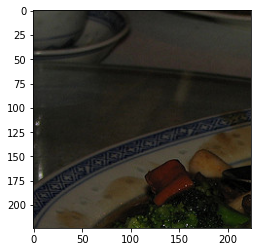

In [26]:
utils.show_result(img_crop, v_boxes, v_labels, v_scores)

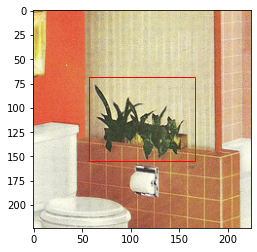

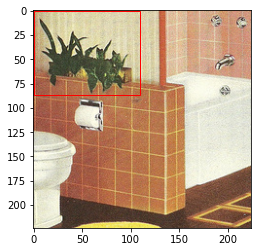

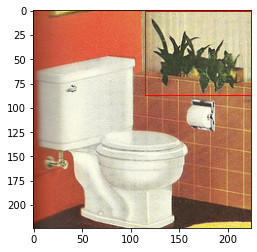

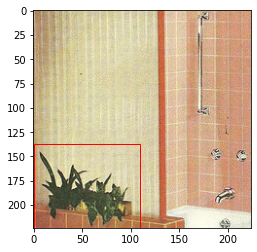

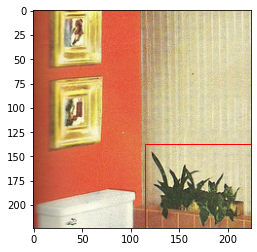

In [46]:
for i in range(0, result_df.shape[0], 5):
    _df = result_df.iloc[i:i+5,:]
    if _df.isnull().values.any():
        continue
    for idx, row in _df.iterrows():
        img = utils.load_image(row['coco_url'], return_tensor=False)
        

        crop_x, crop_y, crop_w, crop_h = decode_nested_list_from_str(row["crop_area"])
        bbox_x, bbox_y, bbox_w, bbox_h = decode_nested_list_from_str(row["true_bbox"])

        

        img_crop = img.crop((crop_x, crop_y, crop_x+crop_w, crop_y+crop_h))
        img_rsz = img_crop.resize((416,416), resample=PIL.Image.BICUBIC)

        fig, ax = plt.subplots()
        plt.imshow(img_crop)
        rect = patches.Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()

    break


In [40]:
_df.head()

,coco_url,crop_area,crop_type,obj_id,true_bbox,true_class
0,http://images.cocodataset.org/val2017/00000046...,"[70, 172, 224, 224]",centr,20490.0,"[57, 68, 109, 87]",64.0
1,http://images.cocodataset.org/val2017/00000046...,"[127, 240, 224, 224]",top_L,20490.0,"[0, 0, 109, 87]",64.0
2,http://images.cocodataset.org/val2017/00000046...,"[12, 240, 224, 224]",top_R,20490.0,"[115, 0, 109, 87]",64.0
3,http://images.cocodataset.org/val2017/00000046...,"[127, 103, 224, 224]",bot_L,20490.0,"[0, 137, 109, 87]",64.0
4,http://images.cocodataset.org/val2017/00000046...,"[12, 103, 224, 224]",bot_R,20490.0,"[115, 137, 109, 87]",64.0
